In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV

from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qksvm.scores import get_scores, print_scores
from qksvm.ProjectedQuantumKernel import ProjectedQuantumKernel
from qksvm.QKSVC import QKSVC

seed = 12345

# plt.style.use('seaborn')
plt.rcParams.update({
    'xtick.labelsize' : 20,
    'ytick.labelsize' : 20,
    'lines.linewidth': 2,
    'axes.titlesize' : 24,
    'xtick.labelsize' : 16,
    'ytick.labelsize' : 16,
    'lines.markersize' : 10,
})

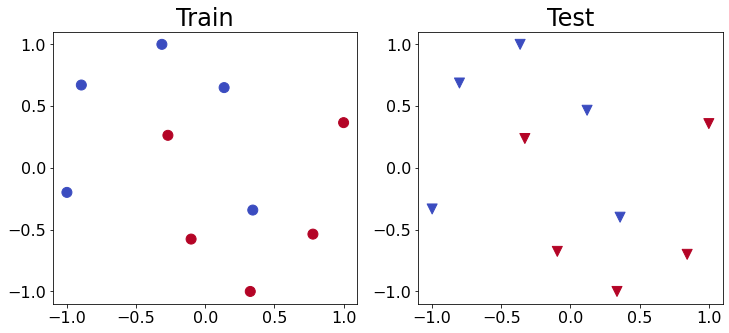

In [2]:
# Generate data set
X_train, y_train = make_moons(10, noise=0.05, random_state=0)
X_test, y_test = make_moons(10, noise=0.05, random_state=1024)

# rescaling
X_train = MinMaxScaler(feature_range=(-1, 1), copy=False).fit_transform(X_train)
X_test = MinMaxScaler(feature_range=(-1, 1), copy=False).fit_transform(X_test)

# Visualize respectively the training and testing set
fig, ax = plt.subplots(1, 2, figsize=[12, 5])
ax[0].scatter(X_train[:,0], X_train[:,1], 
              marker='o', c = plt.cm.coolwarm(np.array(y_train, dtype=np.float32)))
ax[0].set_title('Train')
ax[1].set_title('Test')
ax[1].scatter(X_test[:,0], X_test[:,1], marker='v', c = plt.cm.coolwarm(np.array(y_test, dtype=np.float32)))
plt.show()

In [3]:
# Visualize the decision function, boundary, and margins of +- 0.2
def visualize_decision_bound(clf):
    
    # Create a 10x10 mesh in the data plan 
    x_min, x_max = X_train[:,0].min(), X_train[:,0].max()
    y_min, y_max = X_train[:,1].min(), X_train[:,1].max()
    margin = 0.2
    XX, YY = np.meshgrid(np.linspace(x_min-margin, x_max+margin, 10), 
                         np.linspace(y_min-margin, y_max+margin, 10))
    
    # Calculate the decision function value on the 10x10 mesh
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z_qke = Z.reshape(XX.shape)
    
    # visualize the decision function and boundary
    plt.figure(figsize=(8,8))
    plt.contourf(XX, YY, Z_qke ,vmin=-1., vmax=1., levels=20,
                 cmap=plt.cm.coolwarm, alpha=1)
    plt.scatter(X_train[:,0], X_train[:,1], marker='o', s=100,
                c = plt.cm.coolwarm(np.array(y_train, dtype=np.float32)),
                edgecolor='k')
    plt.scatter(X_test[:,0], X_test[:,1], marker='s', s=100,
                c = plt.cm.coolwarm(np.array(y_test, dtype=np.float32)),
                edgecolor='k')
    plt.contour(XX, YY, Z_qke, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.2, 0, .2])

In [4]:
def visualize_projected_dataset(proj_kernel, X):
    X_proj = [proj_kernel.projected_feature_map(x) for x in X]
    X_proj = np.array(X_proj)
    print(X_proj.shape)

    fig = plt.figure(figsize=plt.figaspect(0.4))
    
    # Original dataset
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(X[:,0], X[:,1], marker='o', s=100,
               c = plt.cm.coolwarm(np.array(y_train, dtype=np.float32)),
               edgecolor=None)

    # Projected dataset
    d = len(X_proj[0]) 
    if d == 2:
        ax = fig.add_subplot(1, 2, 2)
        ax.scatter(X_proj[:,0], X_proj[:,1], marker='s', s=200,
                   c = plt.cm.coolwarm(np.array(y_train, dtype=np.float32)),
                   edgecolor=None)
    elif d == 3:
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        ax.scatter(X_proj[:,0], X_proj[:,1], X_proj[:,2], marker='s', s=200,
                   c = plt.cm.coolwarm(np.array(y_train, dtype=np.float32)),
                   edgecolor=None)
    else:
        # print(d)
        assert False, f"Data dimension is too high to visualize! dim={d}"

    plt.tight_layout()
    plt.show()

# Pauli Feature Map

## Grid Search CV

Best grid search parameters: {'C': 1, 'alpha': 2.0, 'feature_map': ['rx', 'ry', 'cz'], 'n_layers': 2, 'n_qubits': 3}
Best training score: 0.8

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


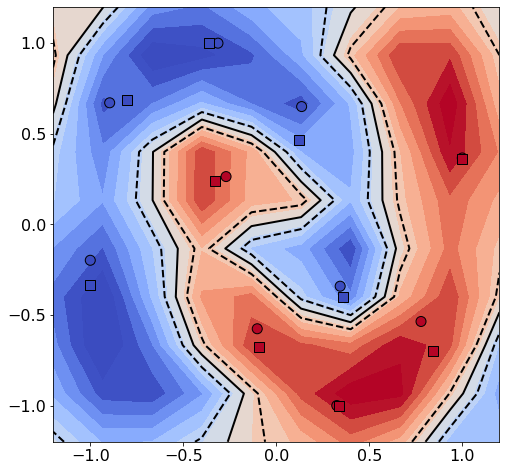

In [5]:
np.random.seed(seed=seed)

param_grid = {
    "alpha": [1.0, 1.5, 2.0, 2.5, 3.0],
    "C": [1],
    "n_layers": [1, 2],
    "n_qubits": [2, 3, 4],
    "feature_map": [
                    ['rx', 'cz'], 
                    ['rx', 'cx'], 
                    ['rx', 'swap'],
                    ['ry', 'cz'], 
                    ['ry', 'cx'], 
                    ['ry', 'iswap'],
                    ['ry', 'crx'],
                    ['rx', 'cry'],
                    ['rx', 'crz'],
                    ['rx', 'ry', 'cz'],
                    ['rx', 'ry', 'cx'],
                    ['rx', 'ry', 'swap'],
                   ],
}

gs = GridSearchCV(
    estimator=QKSVC(entanglement='linear', random_state=seed),
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
)
gs.fit(X_train, y_train)

print('Best grid search parameters:', gs.best_params_)
print('Best training score:', gs.best_score_)

train_scores = get_scores(gs.best_estimator_, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(gs.best_estimator_, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(gs.best_estimator_)

## RX-CRY

### Original QK

     ┌────────────┐                                           ┌────────────┐ 
q_0: ┤ Rx(x[0]*α) ├───────■───────────────────────────────────┤ Ry(x[1]*α) ├─
     ├────────────┤ ┌─────┴──────┐                            └─────┬──────┘ 
q_1: ┤ Rx(x[1]*α) ├─┤ Ry(x[0]*α) ├──────■───────────────────────────┼────────
     ├────────────┤ └────────────┘┌─────┴──────┐                    │        
q_2: ┤ Rx(x[0]*α) ├───────────────┤ Ry(x[1]*α) ├──────■─────────────┼────────
     ├────────────┤               └────────────┘┌─────┴──────┐      │        
q_3: ┤ Rx(x[1]*α) ├─────────────────────────────┤ Ry(x[0]*α) ├──────■────────
     └────────────┘                             └────────────┘               

Train scores:
   Balanced accuracy:  0.80
                  F1:  0.80
             ROC_AUC:  0.80
                 MCC:  0.60

Test scores:
   Balanced accuracy:  0.80
                  F1:  0.80
             ROC_AUC:  0.80
                 MCC:  0.60


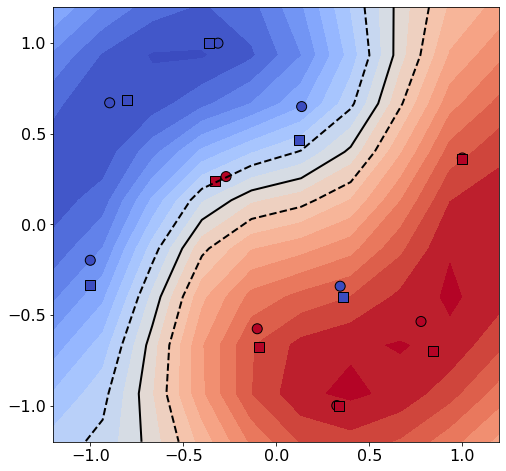

In [6]:
n_features = len(X_train[0])
n_qubits = 4
n_layers = 1

from qksvm.QuantumFeatureMap import QuantumFeatureMap
fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['RX', 'CRY'], entanglement='ring',
)
print(fm.draw(plot_barriers=False, fold=150))

svc = QKSVC(feature_map=fm, alpha=np.pi/2, C=1.0, random_state=seed)
svc.fit(X_train, y_train)

train_scores = get_scores(svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(svc)

### Projected QK

#### xyz_sum

     ┌────────────┐               ┌────────────┐ 
q_0: ┤ Rx(x[0]*α) ├───────■───────┤ Ry(x[1]*α) ├─
     ├────────────┤ ┌─────┴──────┐└─────┬──────┘ 
q_1: ┤ Rx(x[1]*α) ├─┤ Ry(x[0]*α) ├──────■────────
     └────────────┘ └────────────┘               

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


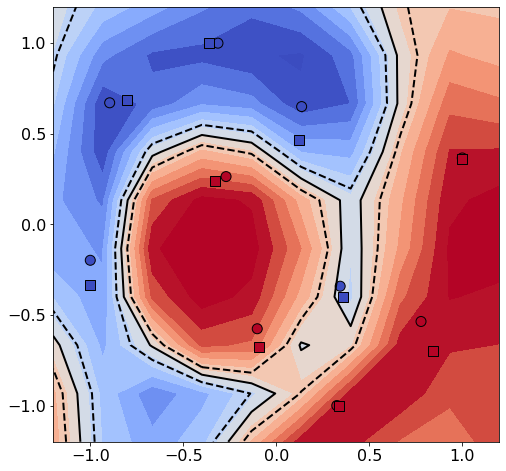

In [7]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 1

from qksvm.QuantumFeatureMap import QuantumFeatureMap
fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['RX', 'CRY'], entanglement='ring',
)
print(fm.draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({fm.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=np.pi/2, projection='xyz_sum', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

(10, 2)


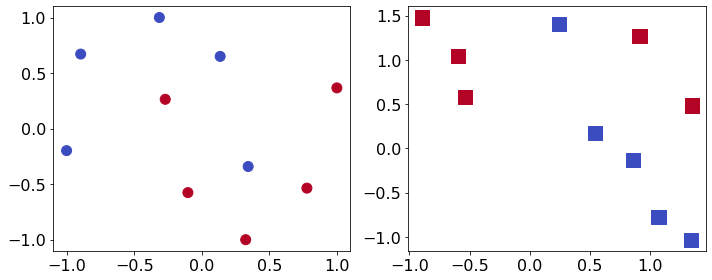

In [8]:
visualize_projected_dataset(proj_kernel, X_train)

#### xyz

     ┌────────────┐               ┌────────────┐ 
q_0: ┤ Rx(x[0]*α) ├───────■───────┤ Ry(x[1]*α) ├─
     ├────────────┤ ┌─────┴──────┐└─────┬──────┘ 
q_1: ┤ Rx(x[1]*α) ├─┤ Ry(x[0]*α) ├──────■────────
     └────────────┘ └────────────┘               

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


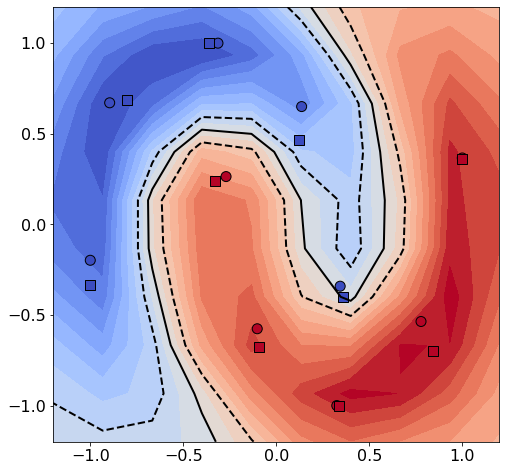

In [9]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 1

from qksvm.QuantumFeatureMap import QuantumFeatureMap
fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['RX', 'CRY'], entanglement='ring',
)
print(fm.draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({fm.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=np.pi/2, projection='xyz', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

# ZZ Feature Map

### Original QK

     ┌───┐┌────────────┐                      ┌───┐┌────────────┐                      
q_0: ┤ H ├┤ Rz(x[0]*α) ├─■────────────────────┤ H ├┤ Rz(x[0]*α) ├─■────────────────────
     ├───┤├────────────┤ │ZZ(x[0]*x[1]*α**2)  ├───┤├────────────┤ │ZZ(x[0]*x[1]*α**2)  
q_1: ┤ H ├┤ Rz(x[1]*α) ├─■────────────────────┤ H ├┤ Rz(x[1]*α) ├─■────────────────────
     └───┘└────────────┘                      └───┘└────────────┘                      

Train scores:
   Balanced accuracy:  0.70
                  F1:  0.70
             ROC_AUC:  0.70
                 MCC:  0.41

Test scores:
   Balanced accuracy:  0.70
                  F1:  0.70
             ROC_AUC:  0.70
                 MCC:  0.41


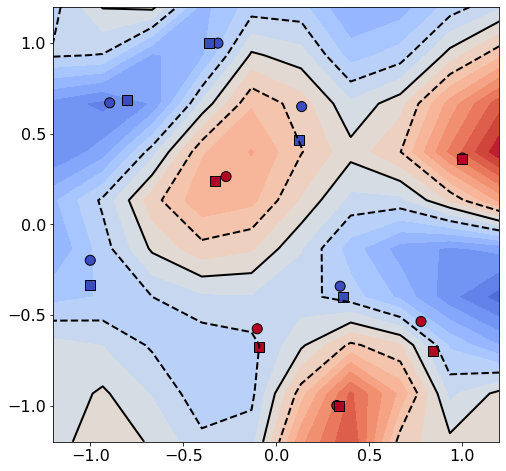

In [10]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 2

from qksvm.QuantumEmbedding import ZZ_FeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

def data_map(x, y):
    return x*y

fm = ZZ_FeatureMap(n_features, n_qubits, n_layers, data_map_func=data_map)
print(fm.draw(plot_barriers=False, fold=150))

qsvc = QKSVC(feature_map=fm, alpha=np.pi/2, C=1.0, random_state=seed)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(qsvc)

### Projected QK

     ┌───┐┌────────────┐                      ┌───┐┌────────────┐                      
q_0: ┤ H ├┤ Rz(x[0]*α) ├─■────────────────────┤ H ├┤ Rz(x[0]*α) ├─■────────────────────
     ├───┤├────────────┤ │ZZ(x[0]*x[1]*α**2)  ├───┤├────────────┤ │ZZ(x[0]*x[1]*α**2)  
q_1: ┤ H ├┤ Rz(x[1]*α) ├─■────────────────────┤ H ├┤ Rz(x[1]*α) ├─■────────────────────
     └───┘└────────────┘                      └───┘└────────────┘                      

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  0.90
                  F1:  0.90
             ROC_AUC:  0.90
                 MCC:  0.82


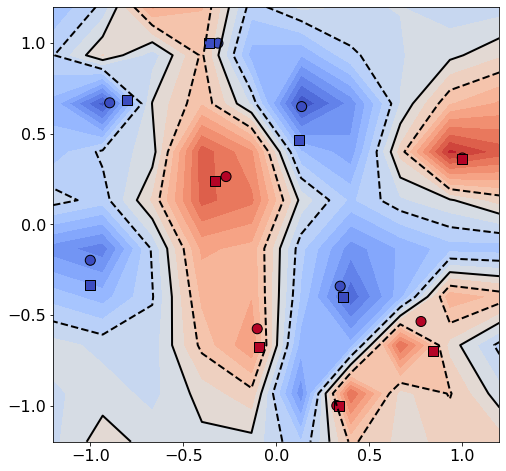

In [11]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 2

from qksvm.QuantumEmbedding import ZZ_FeatureMap

def data_map(x, y):
    return x*y

fm = ZZ_FeatureMap(n_features, n_qubits, n_layers, data_map_func=data_map)
print(fm.draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({fm.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=np.pi/2, projection='xyz', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

# Hamiltonian Evolution Feature Map

## Original QK

      ┌─────────────────────┐ ┌──────────────────────┐ ┌──────────────────────┐┌───────────────────┐┌───────────────────┐                  »
q_0: ─┤ x^-0.50183952461055 ├─┤ y^1.8028572256396647 ├─┤ z^0.9279757672456204 ├┤0                  ├┤0                  ├─■────────────────»
      ├─────────────────────┴┐├──────────────────────┤┌┴──────────────────────┤│  Rxx(0.25*x[0]*α) ││  Ryy(0.25*x[0]*α) │ │ZZ(0.25*x[0]*α) »
q_1: ─┤ x^0.3946339367881464 ├┤ y^-1.375925438230254 ├┤ z^-1.3760219186551894 ├┤1                  ├┤1                  ├─■────────────────»
     ┌┴──────────────────────┤├──────────────────────┤└┬──────────────────────┤└───────────────────┘└───────────────────┘                  »
q_2: ┤ x^-1.7676655513272022 ├┤ y^1.4647045830997407 ├─┤ z^0.4044600469728352 ├────────────────────────────────────────────────────────────»
     └───────────────────────┘└──────────────────────┘ └──────────────────────┘                                                            »
«            

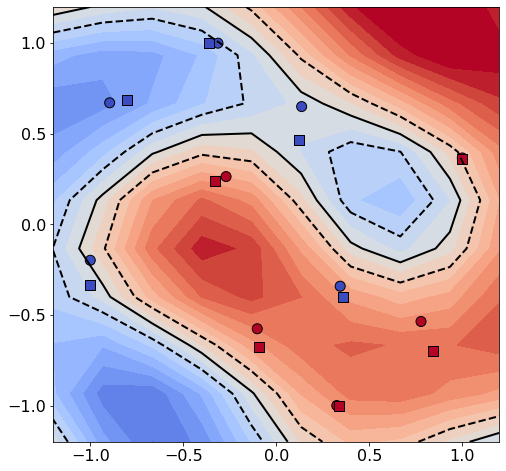

In [12]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 4

from qksvm.QuantumEmbedding import SingleQubitWall
qc1 = SingleQubitWall(n_qubits, random_state=42)

from qksvm.QuantumEmbedding import HamiltonianEvolution 
qc2 = HamiltonianEvolution(n_features, n_qubits, n_trotter)

from qiskit import QuantumRegister, QuantumCircuit
fm = QuantumCircuit(n_qubits)
fm.append(qc1.to_instruction(), fm.qubits)
fm.append(qc2.to_instruction(), fm.qubits)
print(fm.decompose().draw(plot_barriers=False, fold=150))

fm.alpha = qc2.alpha
svc = QKSVC(feature_map=fm, alpha=np.pi/2, C=1.0, random_state=seed)
svc.fit(X_train, y_train)

train_scores = get_scores(svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(svc)

## Projected QK

      ┌─────────────────────┐ ┌──────────────────────┐ ┌──────────────────────┐┌───────────────────┐┌───────────────────┐                  »
q_0: ─┤ x^-0.50183952461055 ├─┤ y^1.8028572256396647 ├─┤ z^0.9279757672456204 ├┤0                  ├┤0                  ├─■────────────────»
      ├─────────────────────┴┐├──────────────────────┤┌┴──────────────────────┤│  Rxx(0.25*x[0]*α) ││  Ryy(0.25*x[0]*α) │ │ZZ(0.25*x[0]*α) »
q_1: ─┤ x^0.3946339367881464 ├┤ y^-1.375925438230254 ├┤ z^-1.3760219186551894 ├┤1                  ├┤1                  ├─■────────────────»
     ┌┴──────────────────────┤├──────────────────────┤└┬──────────────────────┤└───────────────────┘└───────────────────┘                  »
q_2: ┤ x^-1.7676655513272022 ├┤ y^1.4647045830997407 ├─┤ z^0.4044600469728352 ├────────────────────────────────────────────────────────────»
     └───────────────────────┘└──────────────────────┘ └──────────────────────┘                                                            »
«            

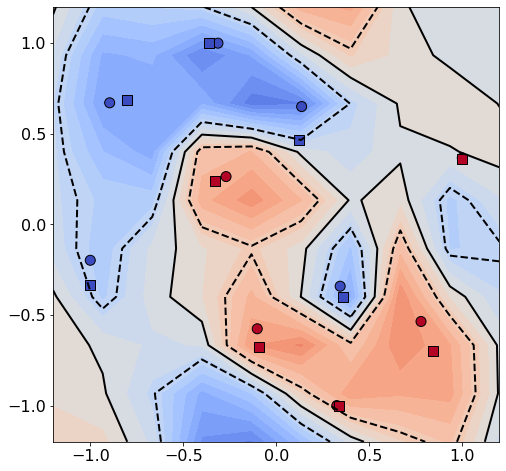

In [13]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 4

from qksvm.QuantumEmbedding import SingleQubitWall
qc1 = SingleQubitWall(n_qubits, random_state=42)

from qksvm.QuantumEmbedding import HamiltonianEvolution
qc2 = HamiltonianEvolution(n_features, n_qubits, n_trotter)

from qiskit import QuantumRegister, QuantumCircuit
fm = QuantumCircuit(n_qubits)
fm.append(qc1.to_instruction(), fm.qubits)
fm.append(qc2.to_instruction(), fm.qubits)
print(fm.decompose().draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({qc2.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=np.pi/2, projection='xyz', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

## Modifications

### Original QK

     ┌────────────┐ ┌───────────────────┐┌───────────────────┐                                                                               »
q_0: ┤ Rx(x[0]*α) ├─┤0                  ├┤0                  ├─■─────────────────────────────────────────────────────────────────────────────»
     ├────────────┤ │  Rxx(0.25*x[0]*α) ││  Ryy(0.25*x[0]*α) │ │ZZ(0.25*x[0]*α) ┌───────────────────┐┌───────────────────┐                   »
q_1: ┤ Rx(x[1]*α) ├─┤1                  ├┤1                  ├─■────────────────┤0                  ├┤0                  ├─■─────────────────»
     ├────────────┤ └───────────────────┘└───────────────────┘                  │  Rxx(0.25*x[1]*α) ││  Ryy(0.25*x[1]*α) │ │ZZ(0.25*x[1]*α)  »
q_2: ┤ Rx(x[0]*α) ├─────────────────────────────────────────────────────────────┤1                  ├┤1                  ├─■─────────────────»
     └────────────┘                                                             └───────────────────┘└───────────────────┘                   »

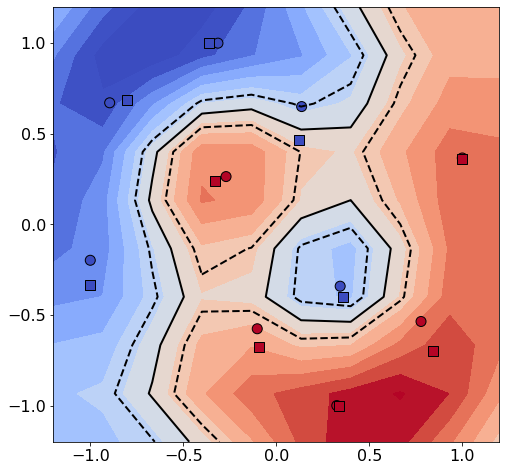

In [14]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 4

from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
alpha = Parameter('α')
qc1 = QuantumCircuit(n_qubits)
qc1.alpha = alpha
for i in range(n_qubits):
    # qc1.u(np.pi/2, alpha*x[i%n_features], alpha*x[i%n_features], i)
    qc1.rx(alpha*x[i%n_features], i)
    # qc1.ry(alpha*x[i%n_features], i)
# entangle(qc1, 'cz', connectivity='linear_')
qc1.barrier()

from qksvm.QuantumEmbedding import HamiltonianEvolution
qc2 = HamiltonianEvolution(n_features, n_qubits, n_trotter)

from qiskit import QuantumCircuit
fm = QuantumCircuit(n_qubits)
fm.append(qc1.to_instruction(), fm.qubits)
x_dict = dict(zip(qc2.parameters, qc1.parameters))
fm.append(qc2.to_instruction(x_dict), fm.qubits)
print(fm.decompose().draw(plot_barriers=False, fold=150))

fm.alpha = qc1.alpha
svc = QKSVC(feature_map=fm, alpha=np.pi/2, C=1.0, random_state=seed)
svc.fit(X_train, y_train)

train_scores = get_scores(svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(svc)

### Projected QK

     ┌────────────┐ ┌───────────────────┐┌───────────────────┐                                                                               »
q_0: ┤ Rx(x[0]*α) ├─┤0                  ├┤0                  ├─■─────────────────────────────────────────────────────────────────────────────»
     ├────────────┤ │  Rxx(0.25*x[0]*α) ││  Ryy(0.25*x[0]*α) │ │ZZ(0.25*x[0]*α) ┌───────────────────┐┌───────────────────┐                   »
q_1: ┤ Rx(x[1]*α) ├─┤1                  ├┤1                  ├─■────────────────┤0                  ├┤0                  ├─■─────────────────»
     ├────────────┤ └───────────────────┘└───────────────────┘                  │  Rxx(0.25*x[1]*α) ││  Ryy(0.25*x[1]*α) │ │ZZ(0.25*x[1]*α)  »
q_2: ┤ Rx(x[0]*α) ├─────────────────────────────────────────────────────────────┤1                  ├┤1                  ├─■─────────────────»
     └────────────┘                                                             └───────────────────┘└───────────────────┘                   »

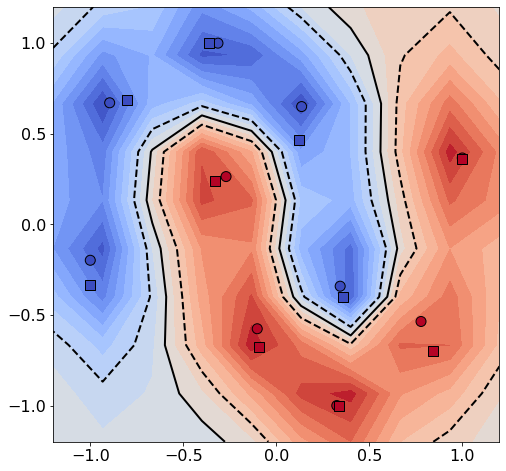

In [15]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 4

from qiskit.circuit import Parameter, ParameterVector
from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
alpha = Parameter('α')
qc1 = QuantumCircuit(n_qubits)
qc1.alpha = alpha
for i in range(n_qubits):
    # qc1.u(np.pi/2, alpha*x[i%n_features], alpha*x[i%n_features], i)
    qc1.rx(alpha*x[i%n_features], i)
    # qc1.ry(alpha*x[i%n_features], i)
# entangle(qc1, 'cz', connectivity='linear_')
qc1.barrier()

from qksvm.QuantumEmbedding import HamiltonianEvolution
qc2 = HamiltonianEvolution(n_features, n_qubits, n_trotter)

from qiskit import QuantumCircuit
fm = QuantumCircuit(n_qubits)
fm.append(qc1.to_instruction(), fm.qubits)
x_dict = dict(zip(qc2.parameters, qc1.parameters))
fm.append(qc2.to_instruction(x_dict), fm.qubits)
print(fm.decompose().draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({qc1.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=np.pi/2, projection='xyz', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

     ┌──────────────────────┐ ┌───────────────────┐┌───────────────────┐                                                            »
q_0: ┤ U(π/2,x[0]*α,x[1]*α) ├─┤0                  ├┤0                  ├─■──────────────────────────────────────────────────────────»
     ├──────────────────────┤ │  Rxx(0.25*x[0]*α) ││  Ryy(0.25*x[0]*α) │ │ZZ(0.25*x[0]*α) ┌───────────────────┐┌───────────────────┐»
q_1: ┤ U(π/2,x[1]*α,x[0]*α) ├─┤1                  ├┤1                  ├─■────────────────┤0                  ├┤0                  ├»
     ├──────────────────────┤ └───────────────────┘└───────────────────┘                  │  Rxx(0.25*x[1]*α) ││  Ryy(0.25*x[1]*α) │»
q_2: ┤ U(π/2,x[0]*α,x[1]*α) ├─────────────────────────────────────────────────────────────┤1                  ├┤1                  ├»
     └──────────────────────┘                                                             └───────────────────┘└───────────────────┘»
«                        ┌───────────────────┐┌───────────────

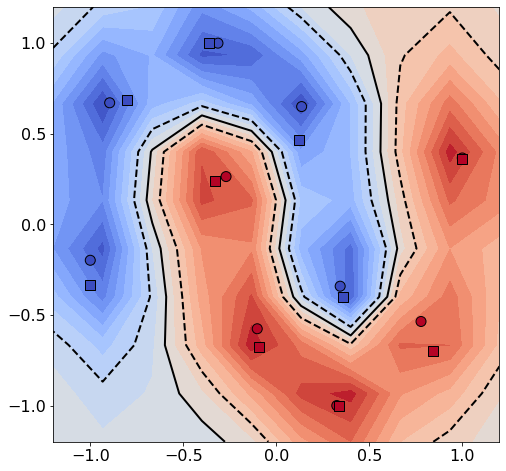

In [16]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 4

from qiskit.circuit import Parameter, ParameterVector
from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
alpha = Parameter('α')
qc1 = QuantumCircuit(n_qubits)
qc1.alpha = alpha
for i in range(n_qubits):
    qc1.u(np.pi/2, alpha*x[i%n_features], alpha*x[(i+1)%n_features], i)
    # qc1.rx(alpha*x[i%n_features], i)
    # qc1.ry(alpha*x[i%n_features], i)
# entangle(qc1, 'cz', connectivity='linear_')
qc1.barrier()

from qksvm.QuantumEmbedding import HamiltonianEvolution
qc2 = HamiltonianEvolution(n_features, n_qubits, n_trotter)

from qiskit import QuantumCircuit
fm = QuantumCircuit(n_qubits)
fm.append(qc1.to_instruction(), fm.qubits)
x_dict = dict(zip(qc2.parameters, qc1.parameters))
fm.append(qc2.to_instruction(x_dict), fm.qubits)
print(fm.decompose().draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({qc1.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=np.pi/2, projection='xyz', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

# Kernel Target Alignement

In [17]:
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.utils import algorithm_globals
from qksvm.QuantumKernelTraining import QKTKernel

algorithm_globals.random_seed = seed
backend = QuantumInstance(
    AerSimulator(
        method='statevector',
        max_parallel_threads=8,
    ),
    seed_simulator=seed, seed_transpiler=seed,
)

## ry-cz-RX

In [18]:
n_features = len(X_train[0])
n_qubits = 4
n_layers = 1

from qksvm.QuantumFeatureMap import QuantumFeatureMap
fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['rx', 'cz', 'RY'], entanglement='linear',
    scale=True,
)
print(fm.draw(plot_barriers=False, fold=150))


     ┌──────────┐           ┌───────────────┐ 
q_0: ┤ Rx(θ[1]) ├──■────────┤ Ry(x[0]*θ[0]) ├─
     ├──────────┤  │        ├───────────────┤ 
q_1: ┤ Rx(θ[2]) ├──■──■─────┤ Ry(x[1]*θ[0]) ├─
     ├──────────┤     │     ├───────────────┤ 
q_2: ┤ Rx(θ[3]) ├─────■──■──┤ Ry(x[0]*θ[0]) ├─
     ├──────────┤        │  ├───────────────┤ 
q_3: ┤ Rx(θ[4]) ├────────■──┤ Ry(x[1]*θ[0]) ├─
     └──────────┘           └───────────────┘ 


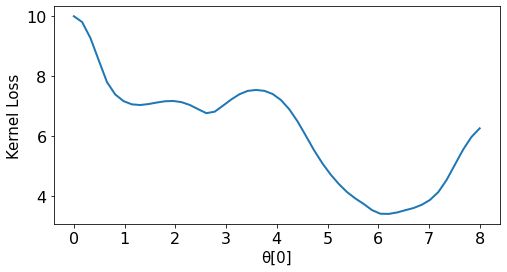

In [19]:
from qksvm.LossFunctions import SVCLoss
from qiskit_machine_learning.kernels import QuantumKernel

kernel = QuantumKernel(fm, user_parameters=fm.train_params, quantum_instance=backend)

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

loss.plot(kernel, X_train, y_train, init_params, grid=[0, 8, 50], show=True)


Train scores:
   Balanced accuracy:  0.80
                  F1:  0.80
             ROC_AUC:  0.80
                 MCC:  0.60

Test scores:
   Balanced accuracy:  0.80
                  F1:  0.80
             ROC_AUC:  0.80
                 MCC:  0.60


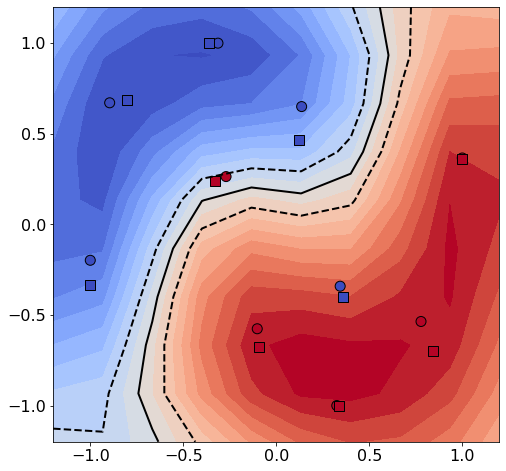

In [20]:
C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 3.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    C=C, class_weight=class_weight,
    seed=seed, plot=False,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(qsvc)

## H-RZ-ry-crz

In [21]:
n_features = len(X_train[0])
n_qubits = 5
n_layers = 1

from qksvm.QuantumFeatureMap import QuantumFeatureMap
fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['H', 'RZ', 'ry', 'crz'], entanglement='ring',
    # gates=['H', 'RZ'], entanglement='ring',
    scale=True,
)
for i in range(n_qubits):
    fm.h(i)
    fm.rz(fm.encod_params[i%fm.num_features], i)
print(fm.draw(plot_barriers=False, fold=150))


     ┌───┐ ┌───────────────┐ ┌──────────┐                                                 ┌───────────┐ ┌───┐┌───────────────┐
q_0: ┤ H ├─┤ Rz(x[0]*θ[0]) ├─┤ Ry(θ[1]) ├──────■──────────────────────────────────────────┤ Rz(θ[10]) ├─┤ H ├┤ Rz(x[0]*θ[0]) ├
     ├───┤ ├───────────────┤ ├──────────┤ ┌────┴─────┐                                    └─────┬─────┘ ├───┤├───────────────┤
q_1: ┤ H ├─┤ Rz(x[1]*θ[0]) ├─┤ Ry(θ[2]) ├─┤ Rz(θ[6]) ├─────■────────────────────────────────────┼───────┤ H ├┤ Rz(x[1]*θ[0]) ├
     ├───┤ ├───────────────┤ ├──────────┤ └──────────┘┌────┴─────┐                              │       ├───┤├───────────────┤
q_2: ┤ H ├─┤ Rz(x[0]*θ[0]) ├─┤ Ry(θ[3]) ├─────────────┤ Rz(θ[7]) ├─────■────────────────────────┼───────┤ H ├┤ Rz(x[0]*θ[0]) ├
     ├───┤ ├───────────────┤ ├──────────┤             └──────────┘┌────┴─────┐                  │       ├───┤├───────────────┤
q_3: ┤ H ├─┤ Rz(x[1]*θ[0]) ├─┤ Ry(θ[4]) ├─────────────────────────┤ Rz(θ[8]) ├─────■────────────┼───────┤ H ├┤ 

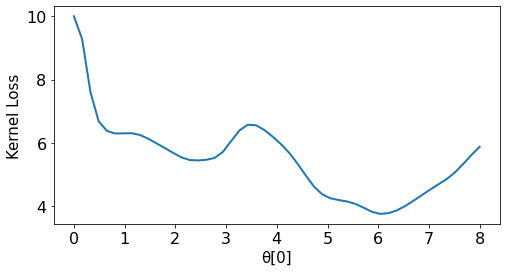

In [22]:
from qksvm.LossFunctions import SVCLoss
from qiskit_machine_learning.kernels import QuantumKernel

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

kernel = QuantumKernel(fm, user_parameters=fm.train_params, quantum_instance=backend)
loss.plot(kernel, X_train, y_train, init_params, grid=[0, 8, 50], show=True)


Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


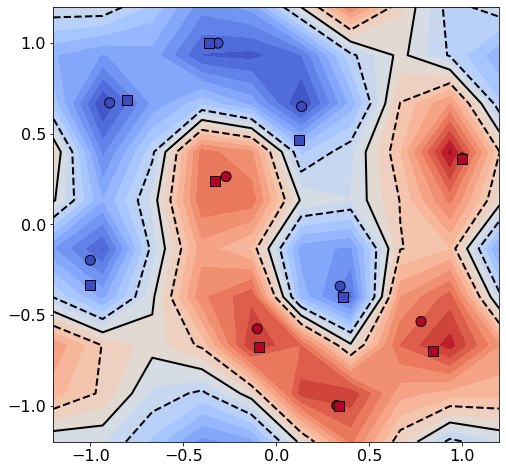

In [23]:
C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 2.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    C=C, class_weight=class_weight,
    seed=seed, plot=False,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(qsvc)

## Covariant quantum kernel map

In [24]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 2

from qksvm.QuantumFeatureMap import QuantumFeatureMap
fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['rx', 'rz', 'cz', 'RY'], entanglement='linear',
    scale=True,
)
print(fm.draw(plot_barriers=False, fold=150))


     ┌──────────┐ ┌──────────┐     ┌───────────────┐ ┌──────────┐ ┌──────────┐     ┌───────────────┐ 
q_0: ┤ Rx(θ[1]) ├─┤ Rz(θ[3]) ├──■──┤ Ry(x[0]*θ[0]) ├─┤ Rx(θ[5]) ├─┤ Rz(θ[7]) ├──■──┤ Ry(x[0]*θ[0]) ├─
     ├──────────┤ ├──────────┤  │  ├───────────────┤ ├──────────┤ ├──────────┤  │  ├───────────────┤ 
q_1: ┤ Rx(θ[2]) ├─┤ Rz(θ[4]) ├──■──┤ Ry(x[1]*θ[0]) ├─┤ Rx(θ[6]) ├─┤ Rz(θ[8]) ├──■──┤ Ry(x[1]*θ[0]) ├─
     └──────────┘ └──────────┘     └───────────────┘ └──────────┘ └──────────┘     └───────────────┘ 


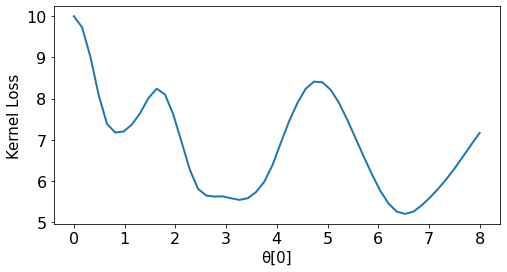

In [25]:
from qksvm.LossFunctions import SVCLoss
from qiskit_machine_learning.kernels import QuantumKernel

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

kernel = QuantumKernel(fm, user_parameters=fm.train_params, quantum_instance=backend)
loss.plot(kernel, X_train, y_train, init_params, grid=[0, 8, 50], show=True)


Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


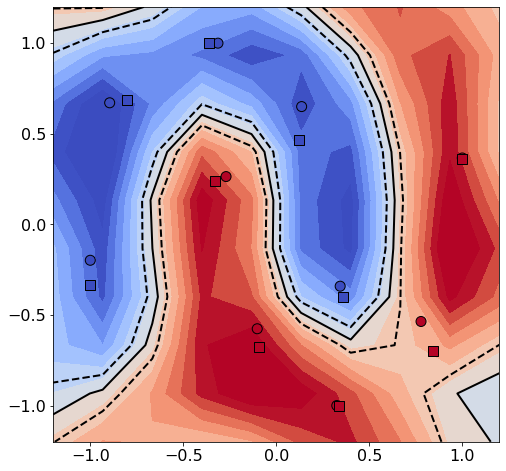

In [26]:
C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 2.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    C=C, class_weight=class_weight,
    seed=seed, plot=False,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(qsvc)

## ZZ embedding

In [27]:
n_features = len(X_train[0])
n_qubits = 2 
n_layers = 2

from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=1+n_layers*n_qubits)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
fm.scale = True

k = 1
for l in range(n_layers):
    # training
    for i in range(n_qubits):
        fm.ry(theta[k], i); k += 1
    # entangle(fm, 'cz', connectivity='linear')
    # embedding
    j = 0
    for i in range(n_qubits):
        fm.h(i)
        fm.rz(theta[0]*x[j%n_features], i); j += 1
    for i in range(n_qubits-1):
        v = theta[0]*x[j%n_features]*x[(j+1)%n_features]; j += 1
        fm.rzz(v, i, (i+1)%n_qubits)
    fm.barrier()
print(fm.draw(plot_barriers=False, fold=150))

     ┌──────────┐┌───┐┌───────────────┐                      ┌──────────┐┌───┐┌───────────────┐                      
q_0: ┤ Ry(θ[1]) ├┤ H ├┤ Rz(x[0]*θ[0]) ├─■────────────────────┤ Ry(θ[3]) ├┤ H ├┤ Rz(x[0]*θ[0]) ├─■────────────────────
     ├──────────┤├───┤├───────────────┤ │ZZ(x[0]*x[1]*θ[0])  ├──────────┤├───┤├───────────────┤ │ZZ(x[0]*x[1]*θ[0])  
q_1: ┤ Ry(θ[2]) ├┤ H ├┤ Rz(x[1]*θ[0]) ├─■────────────────────┤ Ry(θ[4]) ├┤ H ├┤ Rz(x[1]*θ[0]) ├─■────────────────────
     └──────────┘└───┘└───────────────┘                      └──────────┘└───┘└───────────────┘                      


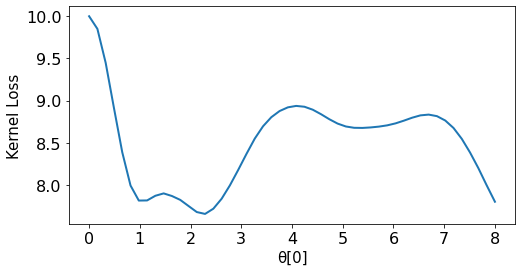

In [28]:
from qksvm.LossFunctions import SVCLoss
from qiskit_machine_learning.kernels import QuantumKernel

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

kernel = QuantumKernel(fm, user_parameters=fm.train_params, quantum_instance=backend)
loss.plot(kernel, X_train, y_train, init_params, grid=[0, 8, 50], show=True)


Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


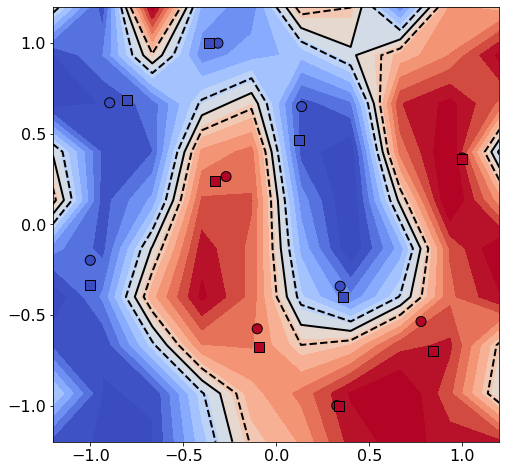

In [29]:
C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 2.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    C=C, class_weight=class_weight,
    seed=seed, plot=False,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(qsvc)

## Hamiltonian evolution

In [30]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 4

from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=1+n_trotter*n_qubits)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
fm.scale = True
p = (n_qubits/3)/n_trotter

# k = 1
# for i in range(n_qubits):
#     fm.rx(theta[k], i)
#     fm.ry(theta[k], i)
#     fm.rz(theta[k], i)
#     k += 1

j = 0
k = 1
for t in range(n_trotter):
    for i in range(n_qubits):
        # fm.rx(theta[k], i); k += 1
        fm.ry(theta[k], i); k += 1
        # fm.rz(theta[k], i); k += 1
    for i in range(n_qubits-1):
        v = theta[0]*p*x[j%n_features]; j += 1
        fm.rxx(v, i, (i+1)%n_qubits)
        fm.ryy(v, i, (i+1)%n_qubits)
        fm.rzz(v, i, (i+1)%n_qubits)
    fm.barrier()
    
print(fm.draw(plot_barriers=False, fold=150))

     ┌──────────┐┌──────────────────────┐┌──────────────────────┐                                                                     »
q_0: ┤ Ry(θ[1]) ├┤0                     ├┤0                     ├─■───────────────────────────────────────────────────────────────────»
     ├──────────┤│  Rxx(0.25*x[0]*θ[0]) ││  Ryy(0.25*x[0]*θ[0]) │ │ZZ(0.25*x[0]*θ[0]) ┌──────────────────────┐┌──────────────────────┐»
q_1: ┤ Ry(θ[2]) ├┤1                     ├┤1                     ├─■───────────────────┤0                     ├┤0                     ├»
     ├──────────┤└──────────────────────┘└──────────────────────┘                     │  Rxx(0.25*x[1]*θ[0]) ││  Ryy(0.25*x[1]*θ[0]) │»
q_2: ┤ Ry(θ[3]) ├─────────────────────────────────────────────────────────────────────┤1                     ├┤1                     ├»
     └──────────┘                                                                     └──────────────────────┘└──────────────────────┘»
«                           ┌──────────┐┌───────

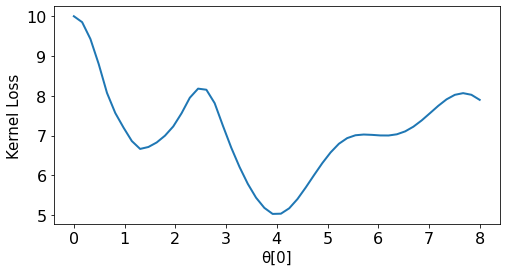

In [31]:
from qksvm.LossFunctions import SVCLoss
from qiskit_machine_learning.kernels import QuantumKernel

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

kernel = QuantumKernel(fm, user_parameters=fm.train_params, quantum_instance=backend)
loss.plot(kernel, X_train, y_train, init_params, grid=[0, 8, 50], show=True)


Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


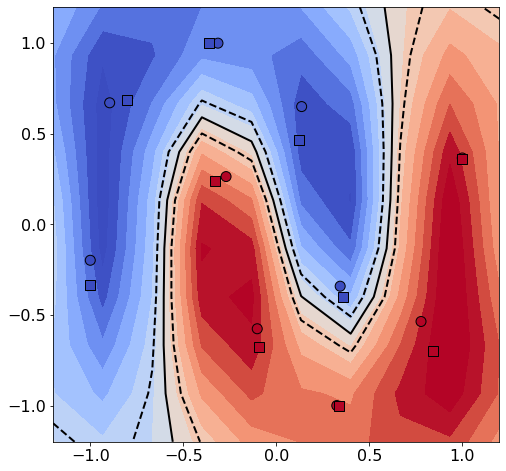

In [32]:
C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 2.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    C=C, class_weight=class_weight,
    seed=seed, plot=False,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(qsvc)

## U maps

In [33]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 2

from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qksvm.QuantumEmbedding import entangle
x = ParameterVector('x', length=n_features)
theta = ParameterVector('θ', length=1+2*n_layers*n_qubits)

fm = QuantumCircuit(n_qubits)
fm.train_params = theta
fm.scale = True

k = 1
for l in range(n_layers):
    for i in range(n_qubits):
        fm.u(theta[0]*x[i%n_features], theta[k], theta[k+1], i)
        k += 2
    entangle(fm, 'cx', connectivity='linear_')
fm.barrier()

print(fm.draw(plot_barriers=False, fold=150))

     ┌────────────────────────┐      ┌────────────────────────┐       
q_0: ┤ U(x[0]*θ[0],θ[1],θ[2]) ├──■───┤ U(x[0]*θ[0],θ[5],θ[6]) ├──■────
     ├────────────────────────┤┌─┴─┐ ├────────────────────────┤┌─┴─┐  
q_1: ┤ U(x[1]*θ[0],θ[3],θ[4]) ├┤ X ├─┤ U(x[1]*θ[0],θ[7],θ[8]) ├┤ X ├──
     └────────────────────────┘└───┘ └────────────────────────┘└───┘  


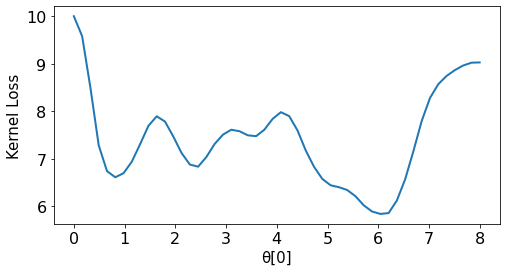

In [34]:
from qksvm.LossFunctions import SVCLoss
from qiskit_machine_learning.kernels import QuantumKernel

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

kernel = QuantumKernel(fm, user_parameters=fm.train_params, quantum_instance=backend)
loss.plot(kernel, X_train, y_train, init_params, grid=[0, 8, 50], show=True)


Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


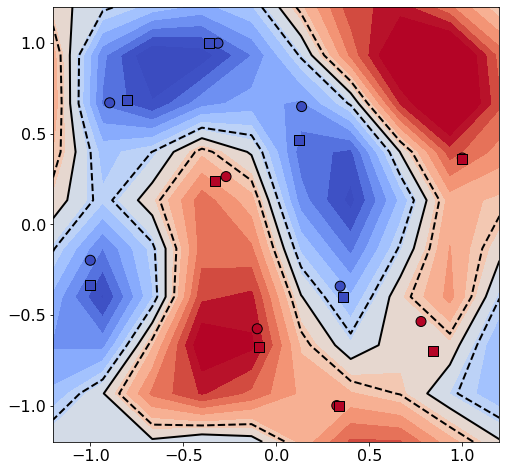

In [35]:
C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 2.0

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    C=C, class_weight=class_weight,
    seed=seed, plot=False,
)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(qsvc)